## Reference Paper:

Nonlinear robust optimization for process design

DOI: 10.1002/aic.15950

In [16]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import fsolve

In [30]:
def solve_model(m):
    opt1 = SolverFactory('gams')
    io_options = dict()

    io_options['solver'] = "ipopth"
    res = opt1.solve(m,
        tee=True,
        add_options = ['option reslim=7200; option optcr=0.0; option limrow=5000'],
        io_options=io_options)

    return res

### Illustrative example of the paper study


\begin{align*}
    \textbf{Min} & (x_1-2)^2 + (x_2-0.2)^2 \\
    s.t. & \frac{4.8-5sin(\pi \sqrt{t})}{1+t^2} x_1^2 - x_2 \le 0 \quad \forall t \in [0, 0.5]\\
    & x_1 \in [-1, 1], x_2 \in [0, 0.2]
\end{align*}

#### An explicit way to write the uncertainty set as shown in equation (4):

$$ S = \{  s| \quad ||M(s - s_1)|| \le \Delta \} $$

where M = 4, s_1 = 0.25, $\Delta$ = 1

In [18]:
def det_ex1():
    m = ConcreteModel()

    m.x1 = Var(bounds=(-1,1))
    m.x2 = Var(bounds=(0,0.2))

    m.t = Param(initialize=0.25)

    def det_constr(model):
        return (4.8-5*math.sin(math.pi*math.sqrt(model.t))) / (1+model.t**2) * model.x1**2 - model.x2 <= 0
    m.c1 = Constraint(rule=det_constr)

    m.obj = Objective(expr=(m.x1-2)**2 + (m.x2-0.2)**2, sense=minimize)

    return m

In [19]:
m1 = det_ex1()
solve_model(m1)
m1.pprint()

--- Job model.gms Start 01/26/24 11:26:25 42.5.0 cf11b917 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\42\gmsprmNT.txt
    C:\Users\zyuliu\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input C:\Users\zyuliu\AppData\Local\Temp\tmp3c0d3dep\model.gms
    Output C:\Users\zyuliu\AppData\Local\Temp\tmp3c0d3dep\output.lst
    ScrDir C:\Users\zyuliu\AppData\Local\Temp\tmp3c0d3dep\225a\
    SysDir C:\GAMS\42\
    CurDir C:\Users\zyuliu\AppData\Local\Temp\tmp3c0d3dep\
    LogOption 3
Licensee: Small MUD - 5 User License                     G221121|0002AP-GEN
          University of Delaware, Chemical and Biomolecular EngineeriDC3967
          C:\Users\zyuliu\Documents\GAMS\gamslice.txt
          License Admin: Marianthi Ierapetritou, mgi@udel.edu              
Processor information: 1 socket(s), 4 core(s), and 8 thread(s) available
GAMS 42.5.0   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- model.gms(94) 2 Mb
--- Starting ex

In [20]:
# Working robust model
def rp_base():
    m = ConcreteModel()

    m.x1 = Var(bounds=(-1,1))
    m.x2 = Var(bounds=(0,0.2))

    m.t = Var()
    m.t.fix()

    m.cuts = ConstraintList()

    m.obj = Objective(expr=(m.x1-2)**2 + (m.x2-0.2)**2, sense=minimize)

    return m


In [21]:
# Initialization
mdet = det_ex1()
mrp = rp_base()
solve_model(mdet)

mrp.x1 = value(mdet.x1)
mrp.x2 = value(mdet.x2)

# Beginning of the algorithm
mrp.t = 0.0266 # referenced from paper, 1st

# feasibility test
value(((4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t)**2) * mrp.x1**2 - mrp.x2) <= 0)

--- Job model.gms Start 01/26/24 11:26:25 42.5.0 cf11b917 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\42\gmsprmNT.txt
    C:\Users\zyuliu\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input C:\Users\zyuliu\AppData\Local\Temp\tmppnv8k1_u\model.gms
    Output C:\Users\zyuliu\AppData\Local\Temp\tmppnv8k1_u\output.lst
    ScrDir C:\Users\zyuliu\AppData\Local\Temp\tmppnv8k1_u\225a\
    SysDir C:\GAMS\42\
    CurDir C:\Users\zyuliu\AppData\Local\Temp\tmppnv8k1_u\
    LogOption 3
Licensee: Small MUD - 5 User License                     G221121|0002AP-GEN
          University of Delaware, Chemical and Biomolecular EngineeriDC3967
          C:\Users\zyuliu\Documents\GAMS\gamslice.txt
          License Admin: Marianthi Ierapetritou, mgi@udel.edu              
Processor information: 1 socket(s), 4 core(s), and 8 thread(s) available
GAMS 42.5.0   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- model.gms(94) 2 Mb
--- Starting ex

False

In [22]:
# Feasibility test failed. Solving the RO at the current point
mrp.cuts.add(expr = (4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t**2)) * mrp.x1**2 - mrp.x2 <= 0)
solve_model(mrp)
mrp.x1.pprint(),mrp.x2.pprint();

--- Job model.gms Start 01/26/24 11:26:26 42.5.0 cf11b917 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\42\gmsprmNT.txt
    C:\Users\zyuliu\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input C:\Users\zyuliu\AppData\Local\Temp\tmpext2pz_u\model.gms
    Output C:\Users\zyuliu\AppData\Local\Temp\tmpext2pz_u\output.lst
    ScrDir C:\Users\zyuliu\AppData\Local\Temp\tmpext2pz_u\225a\
    SysDir C:\GAMS\42\
    CurDir C:\Users\zyuliu\AppData\Local\Temp\tmpext2pz_u\
    LogOption 3
Licensee: Small MUD - 5 User License                     G221121|0002AP-GEN
          University of Delaware, Chemical and Biomolecular EngineeriDC3967
          C:\Users\zyuliu\Documents\GAMS\gamslice.txt
          License Admin: Marianthi Ierapetritou, mgi@udel.edu              
Processor information: 1 socket(s), 4 core(s), and 8 thread(s) available
GAMS 42.5.0   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- model.gms(96) 2 Mb
--- Starting ex

In [23]:
mrp.t = 0.0122 # referenced from paper, 2nd

# feasibility test
value(((4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t)**2) * mrp.x1**2 - mrp.x2) <= 0)

False

In [24]:
# Feasibility test failed. Solving the RO at the current point
mrp.cuts.add(expr = (4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t**2)) * mrp.x1**2 - mrp.x2 <= 0)
solve_model(mrp)
mrp.x1.pprint(),mrp.x2.pprint();

--- Job model.gms Start 01/26/24 11:26:26 42.5.0 cf11b917 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\42\gmsprmNT.txt
    C:\Users\zyuliu\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input C:\Users\zyuliu\AppData\Local\Temp\tmpapfrx13w\model.gms
    Output C:\Users\zyuliu\AppData\Local\Temp\tmpapfrx13w\output.lst
    ScrDir C:\Users\zyuliu\AppData\Local\Temp\tmpapfrx13w\225a\
    SysDir C:\GAMS\42\
    CurDir C:\Users\zyuliu\AppData\Local\Temp\tmpapfrx13w\
    LogOption 3
Licensee: Small MUD - 5 User License                     G221121|0002AP-GEN
          University of Delaware, Chemical and Biomolecular EngineeriDC3967
          C:\Users\zyuliu\Documents\GAMS\gamslice.txt
          License Admin: Marianthi Ierapetritou, mgi@udel.edu              
Processor information: 1 socket(s), 4 core(s), and 8 thread(s) available
GAMS 42.5.0   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- model.gms(99) 2 Mb
--- Starting ex

In [25]:
mrp.t = 0.0036 # referenced from paper, 3rd

# feasibility test
value(((4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t)**2) * mrp.x1**2 - mrp.x2) <= 0)

False

In [26]:
# Feasibility test failed. Solving the RO at the current point
mrp.cuts.add(expr = (4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t**2)) * mrp.x1**2 - mrp.x2 <= 0)
solve_model(mrp)
mrp.x1.pprint(),mrp.x2.pprint();

--- Job model.gms Start 01/26/24 11:26:27 42.5.0 cf11b917 WEX-WEI x86 64bit/MS Windows
--- Applying:
    C:\GAMS\42\gmsprmNT.txt
    C:\Users\zyuliu\Documents\GAMS\gamsconfig.yaml
--- GAMS Parameters defined
    Input C:\Users\zyuliu\AppData\Local\Temp\tmpfixern_6\model.gms
    Output C:\Users\zyuliu\AppData\Local\Temp\tmpfixern_6\output.lst
    ScrDir C:\Users\zyuliu\AppData\Local\Temp\tmpfixern_6\225a\
    SysDir C:\GAMS\42\
    CurDir C:\Users\zyuliu\AppData\Local\Temp\tmpfixern_6\
    LogOption 3
Licensee: Small MUD - 5 User License                     G221121|0002AP-GEN
          University of Delaware, Chemical and Biomolecular EngineeriDC3967
          C:\Users\zyuliu\Documents\GAMS\gamslice.txt
          License Admin: Marianthi Ierapetritou, mgi@udel.edu              
Processor information: 1 socket(s), 4 core(s), and 8 thread(s) available
GAMS 42.5.0   Copyright (C) 1987-2023 GAMS Development. All rights reserved
--- Starting compilation
--- model.gms(102) 2 Mb
--- Starting e

In [27]:
mrp.pprint()

1 Set Declarations
    cuts_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}

3 Var Declarations
    t : Size=1, Index=None
        Key  : Lower : Value  : Upper : Fixed : Stale : Domain
        None :  None : 0.0036 :  None :  True :  True :  Reals
    x1 : Size=1, Index=None
        Key  : Lower : Value             : Upper : Fixed : Stale : Domain
        None :    -1 : 0.227536045807143 :     1 : False : False :  Reals
    x2 : Size=1, Index=None
        Key  : Lower : Value            : Upper : Fixed : Stale : Domain
        None :     0 : 0.20000000009503 :   0.2 : False : False :  Reals

1 Objective Declarations
    obj : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : minimize : (x1 - 2)**2 + (x2 - 0.2)**2

1 Constraint Declarations
    cuts : Size=3, Index=cuts_index, Active=True
        Key : Lower : Body                          : 

In [28]:
mrp.t = 0.01 # referenced from paper, 3rd

# feasibility test
value(((4.8-5*math.sin(math.pi*math.sqrt(value(mrp.t)))) / (1+value(mrp.t)**2) * mrp.x1**2 - mrp.x2) <= 0)

True

### Plotting the problem

C:\Users\zyuliu\.conda\envs\optimization\lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


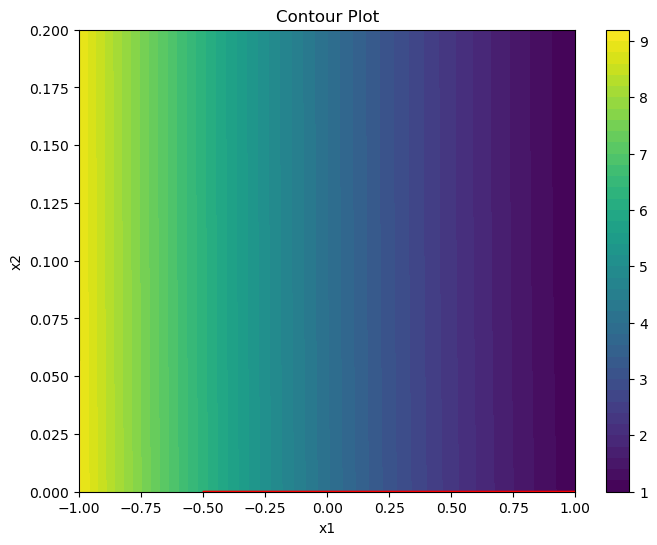

In [29]:
def f(x1, x2):
    return (x1 - 2)**2 + (x2 - 0.2)**2

def constraint(x1, x2, t):
    return (4.8 - 5 * math.sin(math.pi * math.sqrt(t))) / (1 + t**2) * x1**2 - x2

t = 0.25  # deterministic
x1_values = np.linspace(-1, 1, 400)
x2_values = [fsolve(constraint, 0, args=(x1_val, t))[0] for x1_val in x1_values]

# Generate a grid of x1, x2 values
x1 = np.linspace(-1, 1, 400)
x2 = np.linspace(0, 0.2, 400)
x1, x2 = np.meshgrid(x1, x2)

# Apply the constraint to the grid
constraint_values = constraint(x1, x2, t)

# Compute f(x1, x2) over the grid
z = f(x1, x2)

# Plot the contour
plt.figure(figsize=(8, 6))
plt.plot(x1_values, x2_values, 'r-', label='Constraint')

contour = plt.contourf(x1, x2, z, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.title('Contour Plot')
plt.xlabel('x1')
plt.ylabel('x2')

plt.xlim(-1,1)
plt.ylim(0,0.2)
plt.show()
